<p><b><center>Investigating Smooth-Particle Hydrodynamics (SPH) with Python</center></b></p>

<u>Table of Contents</u>
1. Introduction
    1. Project Aim
    2. Project Description
2. Scientific Background
    1. Fluids
        1. Representing Fluids
        2. Studying Fluids
        3. Challenges
        4. Solutions
    2. Smoothed-Particle Hydrodynamics (SPH)
        1. SPH: The Basics
        2. SPH: Practical Implementations
            1. $W$, the Smoothing Function
3. Creating a Particle Simulation
    1. Using `numpy` arrays
    2. Using classes
4. Running Simulations
    1. $n$-Body Problem
        1. Simulation Objectives
    2. Fluid Models: Dam Break
        1. Building `particle` and `particle_array` classes
            1. Initial Conditions
            2. Key Features
        2. Running the Model
        3. Key Takeaways
    3. Fluid Models: Water Drop
    4. Extra Videos
5. Conclusion
    1. Summary
6. References
    1. Sources
    2. Images
7. Appendix: PySPH

# Introduction
## Project Aim
The aim of this notebook is to model fluid dynamics using Python.

## Project Description
[Fluid dynamics](https://en.wikipedia.org/wiki/Fluid_dynamics) is, broadly speaking, the study of how fluids flow. Fluid dynamics has a huge range of interesting applications, such as:
1. [Biomedical Engineering](https://pubmed.ncbi.nlm.nih.gov/34476751/): the design of medical equipment such as vascular stents relies on a good understanding of how blood flows in the body.
2. [Disaster Protection](https://link.springer.com/chapter/10.1007/978-3-211-69356-8_1): tsunami forecasting and risk evaluation requires a good understanding of how the oceans move.
3. [Industrial Design](https://www.dynamiq-eng.co.uk/pages/Fluid_mechanics_dynamics.php): building safe, efficient, and functioning equipment needs a good understanding of how "fluids" such as heat and pressure change over time.
4. [Astrophysics](https://arxiv.org/abs/1109.2219): somewhat surprisingly, we can model space as a fluid as well.

Closer to home, fluid dynamics is also an active field of research in NUS.

<img src="fluid_dynamics_pic.png" 
     width="800" 
     height="1000" />

We can visit the [Physics](https://phyweb.physics.nus.edu.sg/~bcf/) or [Engineering](https://cde.nus.edu.sg/me/wp-content/uploads/sites/11/2019/02/Research-in-Computational-Fluid-Dynamics.pdf) departments to learn more about fluid dynamics.

## Project Goals
With this in mind, the goal of this notebook is to therefore:
- Understand how scientists model fluids computationally.
- Develop a framework for modeling fluids in Python.
- Validate this framework by testing it with simple fluids.

# Scientific Background
## Fluids
### Representing Fluids
Fluids are typically represented as _continuous_ bodies of liquid that obey [certain assumptions](https://en.wikipedia.org/wiki/Fluid_mechanics), namely:
1. Conservation of mass - the amount of liquid in the system will not change.
2. Conservation of energy - the amount of energy in the system will not change.
3. Conservation of momentum - the total momentum in the system will not change.
4. The continuum assumption - although our liquid is continuous, the properties of the liquid ["may vary point-by-point."](http://pillars.che.pitt.edu/student/slide.cgi?course_id=10&slide_id=5.0)

Although these are well-known physical laws, they are phrased as _assumptions_ in our model because we assume that the fluid of interest is an isolated system that does not interact with its surroundings. In real systems, this is obviously not the case, and the above laws will not hold.

### Studying Fluids
Under these assumptions, we can model the various properties of the fluid and how they change over time using a set of mathematical equations. [NASA](https://www.grc.nasa.gov/www/k-12/airplane/nseqs.html) has provided a helpful graphic summarizing the equations used:

![](https://www.grc.nasa.gov/www/k-12/airplane/Images/nseqs.gif)

Oh.

### Challenges
- Solving partial differential equations (PDE) is very hard.
- Solving _several_ PDEs at the same time is even harder (finding closed solutions is an [open problem](https://en.wikipedia.org/wiki/Navier–Stokes_existence_and_smoothness), with a bounty of a million dollars).

Despite these challenges, engineers have been doing it successfully for decades.

### Solutions
**[Computational fluid dynamics](https://www.simscale.com/docs/simwiki/cfd-computational-fluid-dynamics/what-is-cfd-computational-fluid-dynamics/), or CFD for short, provides one solution to such modeling problems.**

The intuition behind CFD lies in high school calculus, and can be summarized as:
1. Differentiating a function gives us the rate of change of the function.
2. Partial differential equations are what happens when you do a lot of differentiation.
3. We can approximate the derivative of a function numerically.

Put together, we can numerically approximate solutions to PDEs. In an ideal world, the derivative $f'(x)$ of a function $f(x)$ is given by the equation $$f'(x)=\lim_{h\to 0}\frac{f(x+h)-f(x)}{h}.$$ In our unideal world, we can set the value of $h$ to $0.005$ (an arbitrary number), and declare that to be the rate of change over time. In other words, we set our time step to $0.005$ seconds (or any other sufficiently small number that you like), and use this to approximate the complicated equations we see above. Informally, we say that we can approximate $f'(x)$ with the following: $$f'(x) \approx \frac{f(x+0.005)-f(x)}{0.005}.$$

This converts the problem from a calculus problem with differentiation and integration to a computational problem, involving millions of addition, subtraction, multiplication, and division operations. To a computer, the latter is much simpler to perform than the former.

This allows us to introduce smoothed-particle hydrodynamics (SPH), a computational method that translates the fancy equations to a much uglier, but simpler to compute version.

## Smoothed-Particle Hydrodynamics (SPH)
### SPH: The Basics
The very first thing done in SPH is to take a closer look at the continuum assumption made above. Recall that the continuum assumption for a fluid says that properties such as density and pressure of the fluid may vary throughout the fluid. SPH takes that to an extreme - we can therefore model the fluid as a large collection of particles, each particle having its own properties such as density and pressure.

Now that we have a very large collection of particles, we need to define the interactions between these particles. As Dan Price [writes](https://arxiv.org/abs/1111.1259),

> SPH starts with the answer to the question: "How do I compute a density given a distribution of point-mass particles?"

Recall that density of an object is given by the mass of the object divided by its volume; in other words, we can think of density as how much "stuff" there is in a fixed part of space. In SPH, we assume that the mass of each of our particles is constant. Therefore, the only thing that can affect the density of a particle is the amount of space it occupies.

How then, do we measure this amount of space? Here comes the tricky part! Intuitively, a particle cannot have a changing volume (think about it: do we expect the volume of a water molecule to change over time? No!). However, under the assumptions in SPH, **a particle is defined as a fixed amount of mass**. In other words, **particles do not represent individual molecules**. In reality, each SPH "particle" is a stand-in for something like 10,000 water molecules.

(Remark: the 10,000 figure given above is _wildly_ inaccurate. A mole of water has $\sim 6\times10^{23}$ water molecules, and if we represent only 10,000 water molecules with a particle, we will require _six quintillion_ SPH particles to simulate 18ml of water. It is likely that an SPH particle is a stand in for several morbillion particles, allowing us to model our fluid systems with a small enough number of particles that our computers will not explode.)

With the knowledge that each SPH particle is actually several morbillion water molecules, this allows us to introduce the notion of _density_ for an SPH particle. Several morbillion water molecules are obviously not a point mass, and will occupy a certain amount of space, hence giving us the density of the SPH particle.

### SPH: Practical Implementations
Now that we've introduced the notion of SPH particles, what exactly can we do with them? The short answer is that we can use these SPH particles to model how the fluid changes over time. SPH allows us to derive the equations of motion for each SPH particle given the positions and density of other SPH particles, through the following equation: $$\frac{d\mathbf{v}_i}{dt}=-\sum_jm_j\left(\frac{P_i}{\rho_i^2}+\frac{P_j}{\rho_j^2}\right)\nabla W(|\mathbf{r}_i-\mathbf{r}_j|,h),$$ where $\frac{d\mathbf{v}_i}{dt}$ is the acceleration of the $i$th particle, $m_j$ is the mass of the $j$th particle, $P_i$ and $P_j$ are the pressures acting on the $i$th and $j$th particles, $\rho_i$ and $\rho_j$ are the densities of the $i$th and $j$th particles, and $\nabla W(|\mathbf{r}_i-\mathbf{r}_j|,h)$ is the derivative of a smoothing function, which we'll see more of in the next section.

That was a whole chunk of mathematics, but **the key takeaway is that we can compute the acceleration of an SPH particle through a lot of simple mathematical operations (addition, subtraction, division, multiplication), without solving any differential equations.**

#### $W$, the Smoothing Function
The smoothing function is a fancy mathematical way of saying that the particles which are closer to each other have a greater effect on each other. The [Gaussian Kernel](https://pages.stat.wisc.edu/~mchung/teaching/MIA/reading/diffusion.gaussian.kernel.pdf.pdf) is a commonly used smoothing function that is shaped like a bell curve, with the height of the graph representing the effect of the particles surrounding it.

![](http://www.imagemet.com/WebHelp6/Content/Images/Gauss3D.png)

To summarize, the smoothing function is nothing but a fancy way of saying that particles close to each other have a greater effect on each other than particles which are far apart.

# Creating a Particle Simulation
Our goal is to therefore model particles in Python. Prior to writing code, we need to carefully consider the requirements from our code. It is always good to start our design by considering the demands placed on it. We will need two things: particles, and a way for the particles to interact.

Our particles will need the following attributes:
1. Mass
2. Density
3. Pressure
4. Position (3D vector)
5. Direction (3D vector)
6. Acceleration (3D vector)

One possible way of storing them is as a `numpy` array of floats.

The second thing we need is a way for the particles to interact: how do we calculate the distance between two particles, or calculate the next position of the particle, given its current position, velocity, and acceleration? We can accomplish this through writing fucntions.

## Using `numpy` arrays
Here is some pseudocode for only five particles.

```python
import numpy as np
from matplotlib import pyplot as plt

# Creates our array of particles
particles = []
for i in range(5):
    particles.append(np.array(["""Particle data here!"""]))
    
# Implementing the fluid equations
timestep = 0.01 # Sets the time step
def update_particles(particles, timestep):
    """
    Complex mathematical equations here!
    This function will update the particle positions and
    items in our list of particles.
    """

# Running the simulation
start_time = 0
end_time = 10 # A 10 second simulation!
particle_position_data = [] # To store the particle positions at each time step

while (start_time < end_time):
    particle_position_data.append(["""Extract the data using list comprehension"""])
    update_particles(particles, timestep)
    start_time += timestep
    
# Plotting the particles
ax = plt.axes(projection='3d')
for i in range(5):
    # All data is taken from particle_position_data
    x = """X coordinates of one particle over time"""
    y = """Y coordinates of one particle over time"""
    z = """Z coordinates of one particle over time"""
    ax.plot3D(x, y, z)
plt.show()
```

The above pseudocode provides a framework for our SPH simulation. We can turn it into a series of steps for modelling _any_ SPH simulation:
1. Initialize our particles.
2. Define our time step and our functions to update the particle data.
3. Run the simulation, storing the position data of the particles at each time step.
4. Use `matplotlib` to plot the movement of the particles over time.

## Using classes
Although the above code is perfectly functional, it is neither pretty nor extensible. If our particles are arrays of floats, it is tough for us to remember what exactly it is - is index 5 supposed to be the y-coordinate of the particle? Or is it referring to the density of the particle?

Python allows us to create new data types, known as _classes_, and define functions that allow us to interact between objects of this data type. We can therefore define a new `Particle` data type in Python, that allows us to interact with particles much easier. In the code below, we create a new data type called `ExampleParticle`, and show how to work with it. As we'll see shortly, when we define a new data type, we must also define the attributes that variables of that data type have, as well as some functions that define the .

In [1]:
class ExampleParticle():
    """
    A simple particle class for demonstrating
    classes. Particles are assumed to have constant
    mass, and only have a position and velocity.
    ...
    Attributes
    ----------
    p : list
        List with three elements, representing the
        particle's position in 3D space.
        
    d : list
        List with three elements, representing the
        particle's direction vector in 3D space.

    Methods
    -------
    getPos()
        Returns position of the particle.
        
    getDir()
        Returns direction vector of the particle.

    getMagnitude()
        Returns magnitude of the direction vector.
        
    setPos(newPos)
        Updates position of the particle.
        
    setDir(newDir)
        Updates direction vector of the particle.
    """

    def __init__(self, position, direction):
        self._p = position
        self._d = direction
    
    def __str__(self):
        return f"Current position: {self._p}. Current direction: {self._d}."
    
    def getPos(self):
        return self._p
    
    def getDir(self):
        return self._d

    def getMagnitude(self):
        return np.linalg.norm(self._p)
    
    def setPos(self, newPos):
        self._p = newPos
        
    def setDir(self, newDir):
        self._d = newDir

In [2]:
# Initializing a new ExampleParticle with
# position (0, 0, 0) and direction vector
# (1, -2, 3).
exampleParticle1 = ExampleParticle([0, 0, 0], [1, -2, 3])

print(exampleParticle1)

# Changing the position of the particle to
# (3, 5, -1).
exampleParticle1.setPos([3, 5, -1])

print(exampleParticle1)
print(exampleParticle1.getPos())

Current position: [0, 0, 0]. Current direction: [1, -2, 3].
Current position: [3, 5, -1]. Current direction: [1, -2, 3].
[3, 5, -1]


We can now proceed to construct more complex classes to model our particles, taking into account factors such as mass and density. The later sections will further elaborate on the construction of new classes to model particles and physical systems in Python.

# Running Simulations
## $n$-Body Problem
We first begin by modeling the [$n$-body problem](https://en.wikipedia.org/wiki/N-body_problem), a classic demonstration of the style of computation demanded by SPH. The $n$-body problem has a relatively simple statement: given a bunch of particles which interact with each other through the gravitational force of attraction, predict their movement in 3D space over time. The subsequent code blocks will walk us through the class-based framework described above.

### Simulation Objectives
- Compute the interactions between many particles.
- Use `matplotlib` to visualize their interactions over time.

In [18]:
import numpy as np 
import random
import matplotlib.pyplot as plt

In [24]:
class n_body_particle():
    """
    Creates the attributes needed within a particle.
    
    Methods:
        p: 3d position vector
        d: 3d direction vector
        a: 3d acceleration vector.
        dt : time step used in the calculation
    """
    def __init__(self, position, direction):
        self.p = np.array(position, dtype = float)
        self.d = np.array(direction, dtype = float)
        self.a = np.array([0,0,0], dtype = float)
        self.dt = 0.01

In [27]:
class n_body_sim():
    """
    Generates n number of particles. Used to calculate the following:
    1. Acceleration
    2. Velocity
    3. Displacement
    
    Methods
    1. __init__
        Takes in parameters n, dims and seed.
        n is the number of particles
        dims are refering to the boundaries which dictate where my particles are being generated in.
        seed refers to the seed number for which random is being used.
    
        self.mass: arbitrary value, self dictated
        self.grav: Newton's graviational constant
        self.particles: Creates a list of particles (refer to the next class)
    
    2. calc_accel:
        Calculates the acceleration of each particle and updates the particle itself.
        
    3. calc_veloc:
        Calculates the velocity of each particle and updates the particle itself.
    
    4. move:
        Particles are updated by one time step.
    """
    
    def __init__(self, n, dims, seed = 4):
        self.lbound = dims[0]
        self.ubound = dims[1]
        self.seed = random.seed(seed)
        self.mass = 10e18
        self.grav = 6.67* (10**-11)
        
        pPositions = []
        for i in range(n):
            pPositions.append(
                [random.uniform(self.lbound, self.ubound),
                 random.uniform(self.lbound, self.ubound),
                 random.uniform(self.lbound, self.ubound)])
        self.particles = [n_body_particle(pPositions[i], [0, 0, 0]) for i in range(n)]
    
    def calc_accel(self, softening = 0.1):
        for p1 in self.particles:
            temp = np.array([0,0,0]) #This resets the acceleration of my particle
            for p2 in self.particles:
                if id(p1) != id(p2):
                    dx = p1.p[0] - p2.p[0]
                    dy = p1.p[1] - p2.p[1]
                    dz = p1.p[2] - p2.p[2]
                    
                    denominator = (dx**2 + dy**2 + dz**2 + softening**2)**(-1.5)
                    
                    temp[0] += self.grav * (dx * denominator) * self.mass
                    temp[1] += self.grav * (dy * denominator) * self.mass
                    temp[2] += self.grav * (dz * denominator) * self.mass
            p1.a = temp
    
    def calc_veloc(self):
        for p in self.particles:
            p.d += p.a * p.dt / 2
            
    def move(self):
        for p in self.particles:
            p.p += (p.d * p.dt)

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

#Creation of my particle
plot_particles = n_body_sim(n = 50, dims = [-100, 100])
duration = 1
dt = 0.01
table = {}
def memoize():
    global table, duration, dt
    step = 0
    while step <=duration:
        plot_particles.move()
        plot_particles.calc_accel()
        plot_particles.calc_veloc()
        temp = []
        for particle in plot_particles.particles:
            temp.append(list(particle.p))
        table[step] = temp
        step += dt
    return table
y = memoize()
print("Data generated!")

Data generated!


<IPython.core.display.Javascript object>


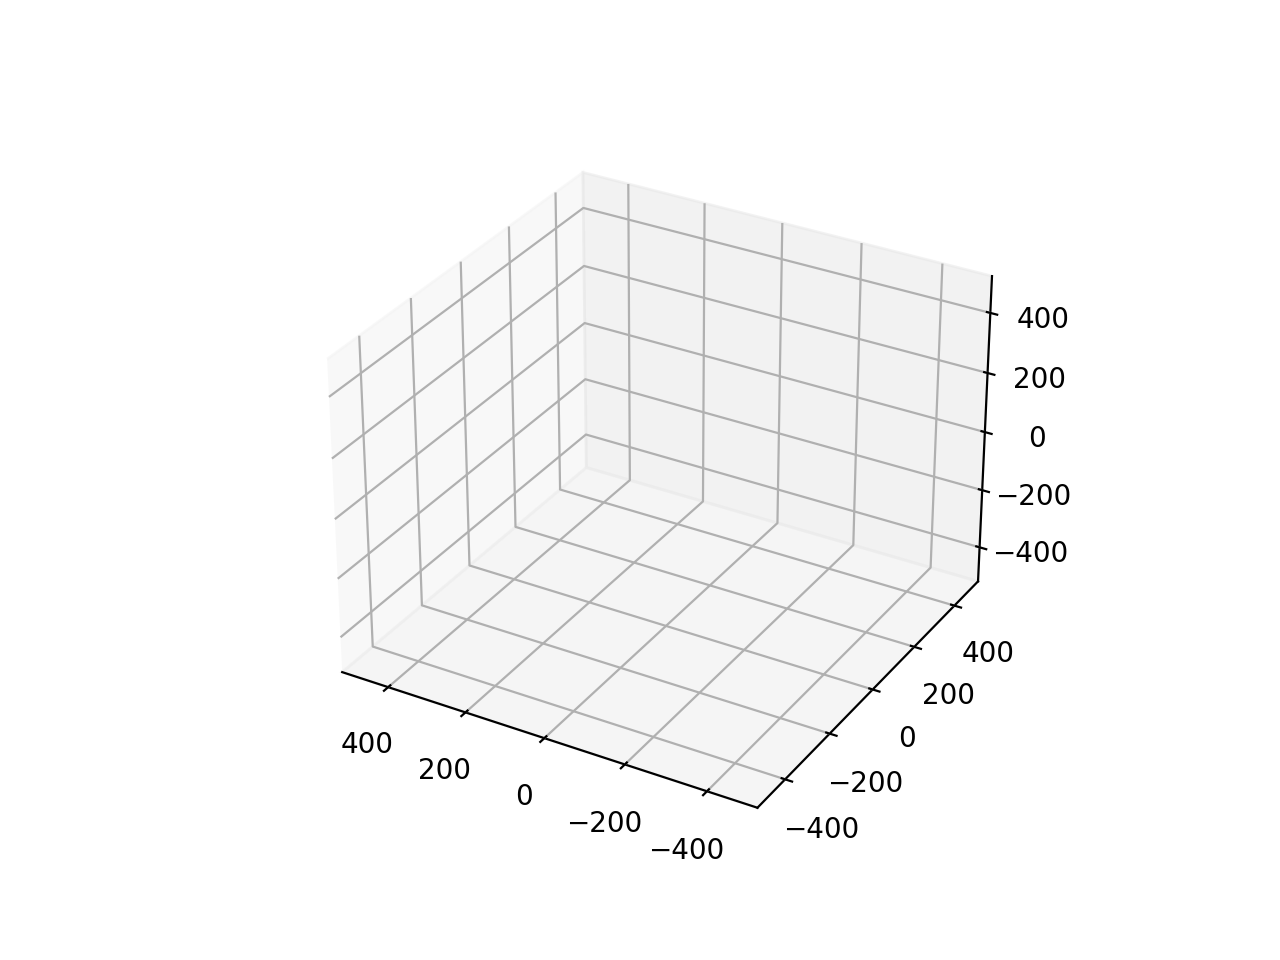

In [33]:
%matplotlib notebook

# Adapted from
# https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

##############################################################
fig = plt.figure()                                           #
ax = fig.add_subplot(111, projection='3d')                   #
#Creating a global variable scat to store particle positions #
scat = ax.scatter([], [], [])                                #
##############################################################

my_timer = 0
dt = 0.01

def init():
    """
    Creates my starting particle positions on the graph
    """
    ax.clear()
    ax.set_xlim3d([-500, 500])
    ax.invert_xaxis()
    ax.set_ylim3d([-500, 500])
    ax.set_zlim3d([-500, 500])
    scat = ax.scatter(
        [particle[0] for particle in table[my_timer]],
        [particle[1] for particle in table[my_timer]],
        [particle[2] for particle in table[my_timer]]
    )
    return scat,


def animate(frame):
    global my_timer, dt
        
    scat._offsets3d = (
        [particle[0] for particle in table[my_timer]],
        [particle[1] for particle in table[my_timer]],
        [particle[2] for particle in table[my_timer]]
    )
    my_timer += dt
    return scat,

#Interval here delays the time per frame shown
ani = FuncAnimation(fig, animate, frames=duration, init_func=init, blit=False, interval = 80)
plt.show()

## Fluid Models: Dam Break
The [dam break problem](https://www.worldscientific.com/doi/pdf/10.1142/9789813223882_0001) is a classic problem in fluid dynamics that simulates what happens when a dam is suddenly broken. In the dam break problem, a body of water is initially contained in an area, and the simulation starts when the walls containing the body of water are removed (the dam breaking). The dam break problem has been [written extensively on](https://pysph.readthedocs.io/en/latest/design/overview.html?highlight=dam%20break#the-dam-break-problem), and we therefore know what to expect from our model. We begin by building the necessary classes to support this model.

### Building `particle` and `particle_array` classes
We begin building our SPH model by defining the `particle` and `particle_array` data types. Variables that are of a `particle` data type require many characteristics, such as a position and direction vector, density, and pressure. Our `particle_array` data type needs to be able to store an array of particles, and update their positions, accelerations, and so on.

#### Initial Conditions
Many of the initial conditions for our simulations can be found in the `__init__` functions in both the `particle` and `particle_array` class. These include values such as the initial velocity of the particles, or the initial positions of the particles in the simulation.

#### Key Features
- The timestep of the simulation can be adjusted by changing the `dt` variable in the `__init__` function of the `particle` class.
- The `update_sim()` function in the `particle_array` class will update the status of all particles in the simulation for the next timestep.
- The `for` loop in the `__init__` function of the `particle_array` class determines the initial positions of the particles in the simulation.
- The sources for the relevant physics equations are provided in the comments within the class.
- The number of particles in the simulation and the boundaries of the simulation are not defined within the two classes.

In [11]:
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib import animation

In [2]:
class particle():
    """
    Variables
    ----------
    p (numpy array) : particle's position in 3D space
        
    d (numpy array) : particle's direction vector in 3D space
    
    a (numpy array) : particle's acceleration vector in 3D space
    
    g (numpy array) : direction vector of gravity
        
    m (float) : mass of the particle
    
    dt (float) : timestep used in the simulation, in seconds
    
    initrho (float) : initial density of the particle
    
    rho (float) : current density of the particle
    
    pre (float) : current pressure of the particle
    
    vmax (float) : maximum velocity of the particle
    """
    
    def __init__(self, position, direction):
        self.p = np.array(position)
        self.d = np.array(direction)
        self.a = np.array([0, 0, 0])
        self.g = np.array([0, 0, 9.81])
        self.m = 1
        self.dt = 0.25
        self.initrho = 1
        self.rho = 0
        self.pre = 0
        self.vmax = 10
    
    def get_magnitude(self):
        return np.linalg.norm(self.p)
    
    def get_pos(self):
        return self.p
    
    def set_pos(self, new_pos):
        self.p = new_pos
    
print("Particle class built!")

Particle class built!


In [3]:
class particle_array():
    """
    Variables
    ----------
    seed (int) : seed for particle position generator
    
    xmin, xmax, ymin,
    ymax, zmin, zmax (int) : boundaries of simulation
        
    particles (list) : list of particles in simulation

    Functions
    -------
    __init__(n, dims, seed) : starts a simulation with
                              n particles, bounded by dims.
                              dims is a list with 6 elements.
                              
    calc_acc() : updates acceleration of particles
            
    calc_vel() : updates velocity of particles

    move() : updates position of particles

    calc_density() : updates density of particles

    calc_pressure() : updates pressure of particles

    gaus_kern(p1, p2, h = 1, d = 3): calculates gaussian kernel
                                     given particles p1 and p2

    dgaus_kern(p1, p2, h = 1, d = 3): calculates derivative of
                                      gaussian kernel given
                                      particles p1 and p2

    get_all_pos() : returns the position of the particles
    
    update_sim() : updates all of the above
    """
    
    def __init__(self, n, dims, seed = 4):
        # Seed for generating pseudorandom particle positions
        self.seed = random.seed(seed)
        
        # Sets boundaries for the simulation
        self.xmin = dims[0]
        self.xmax = dims[1]
        self.ymin = dims[2]
        self.ymax = dims[3]
        self.zmin = dims[4]
        self.zmax = dims[5]
        
        # Generates particles with a random starting position
        pPositions = []
        for i in range(n):
            pPositions.append([
                random.uniform(self.xmax - 0.5, self.xmax),
                random.uniform(self.ymin, self.ymax),
                random.uniform(self.zmin, self.zmin + 5)
            ])    
        self.particles = [particle(pPositions[i], [0, 0, 0]) for i in range(n)]
        
        # Calculate initial density, pressure, acceleration, and velocity
        # based on the position of the other particles.
        self.calc_density()
        self.calc_pressure()
        self.calc_acc()
        self.calc_vel()
            
    # Equation (14) from https://pmocz.github.io/manuscripts/pmocz_sph.pdf
    def calc_acc(self):
        for p1 in self.particles:
            temp_acc = np.array([0,0,0], dtype = float)
            for p2 in self.particles:
                if id(p1) != id(p2):
                    temp_acc += p2.m * ((p1.pre / (p1.rho ** 2)) + (p2.pre / (p2.rho ** 2))) * (self.dgaus_kern(p1, p2))  
            p1.a=temp_acc
            
    def calc_vel(self):
        for p in self.particles:
            new_vel = p.d + (p.a * p.dt) - (p.g * p.dt)
            magnitude = np.linalg.norm(new_vel)
            if magnitude > p.vmax:
                new_vel = (p.vmax / magnitude) * new_vel
            p.d=new_vel

    def move(self):
        for p in self.particles:
            new_pos = p.get_pos() + (p.d * p.dt)
            
            # Checks if the particle is hitting the boundaries
            if new_pos[0] < self.xmin:
                new_pos[0] = self.xmin
                p.d[0] *= -0.75
            if new_pos[0] > self.xmax:
                new_pos[0] = self.xmax
                p.d[0] *= -0.75
            if new_pos[1] < self.ymin:
                new_pos[1] = self.ymin
                p.d[1] *= -0.75
            if new_pos[1] > self.ymax:
                new_pos[1] = self.ymax
                p.d[1] *= -0.75
            if new_pos[2] < self.zmin:
                new_pos[2] = self.zmin
                p.d[2] *= -0.75
            if new_pos[2] > self.zmax:
                new_pos[2] = self.zmax
                p.d[2] *= -0.75
            p.set_pos(new_pos)
                           
    # Equation (15) from https://pmocz.github.io/manuscripts/pmocz_sph.pdf
    def calc_density(self):
        for p in self.particles:
            temp = 0
            for p2 in self.particles:
                if id(p) != id(p2):
                    temp += p2.m * self.gaus_kern(p, p2)
            p.rho=temp

    # Equation (3) from https://iopscience.iop.org/article/10.1088/1742-6596/1985/1/012003/pdf
    def calc_pressure(self):
        for p in self.particles:
            p.pre = (((0.001**2) * 1)/7) * ((p.rho / 1)**7 - 1)
            
    # Equation (6) from https://pmocz.github.io/manuscripts/pmocz_sph.pdf
    def gaus_kern(self, p1, p2, h = 1, d = 3):
        dir_vec = p1.get_pos() - p2.get_pos()
        dist_between = np.linalg.norm(dir_vec)
        return ((h * (np.pi ** (1/2))) ** -d) * (np.e ** (-(dist_between ** 2) / (h ** 2)))
    
    # Derived from above
    def dgaus_kern(self, p1, p2, h = 1, d = 3):
        dir_vec = p1.get_pos() - p2.get_pos()
        dist_between = np.linalg.norm(dir_vec)
        return dir_vec * (2 * (h ** -2)) * ((h * (np.pi ** (1/2))) ** -d) * (np.e ** (-(dist_between ** 2) / (h ** 2)))
            
    def get_all_pos(self):
        all_pos = []
        for i in self.particles:
            all_pos.append(i.get_pos())
        return all_pos
    
    def update_sim(self):
        self.move()
        self.calc_density()
        self.calc_pressure()
        self.calc_acc()
        self.calc_vel()
        
print("Particle array class built!")

Particle array class built!


### Running the Model
Having built the model, we can now use the model to generate the positions of the particles at different timesteps, and use that to plot a visualization of the movement of the particles over time. This is somewhat similar to the Lorenz Attractor from [class](https://sps.nus.edu.sg/sp2273/numerical-solutions-good.html#exercise-1-the-lorentz-attaractor), where we obtain the position of a particle over time and use it to plot a visualization in `matplotlib`.

In the simulation we are creating below, we are creating a particle array with 250 particles and storing it in a variable named `dam_break`. Our simulation will run for a total of 1 second, with a timestep of 0.01 seconds for a total of 100 timesteps.

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

# Creating data for graph plotting
dam_break = particle_array(250, [0, 10, 0, 3, 0, 10])
duration = 1 # length of simulation, in seconds
dt = 0.01 # timestep used for each frame of simulation
table = {}

def memoize():
    global table, duration, dt
    current_time = 0
    while current_time <= duration:
        table[current_time] = dam_break.get_all_pos()
        dam_break.update_sim()
        current_time += dt
    return table
x = memoize()
print("Values generated!")

Values generated!


<IPython.core.display.Javascript object>


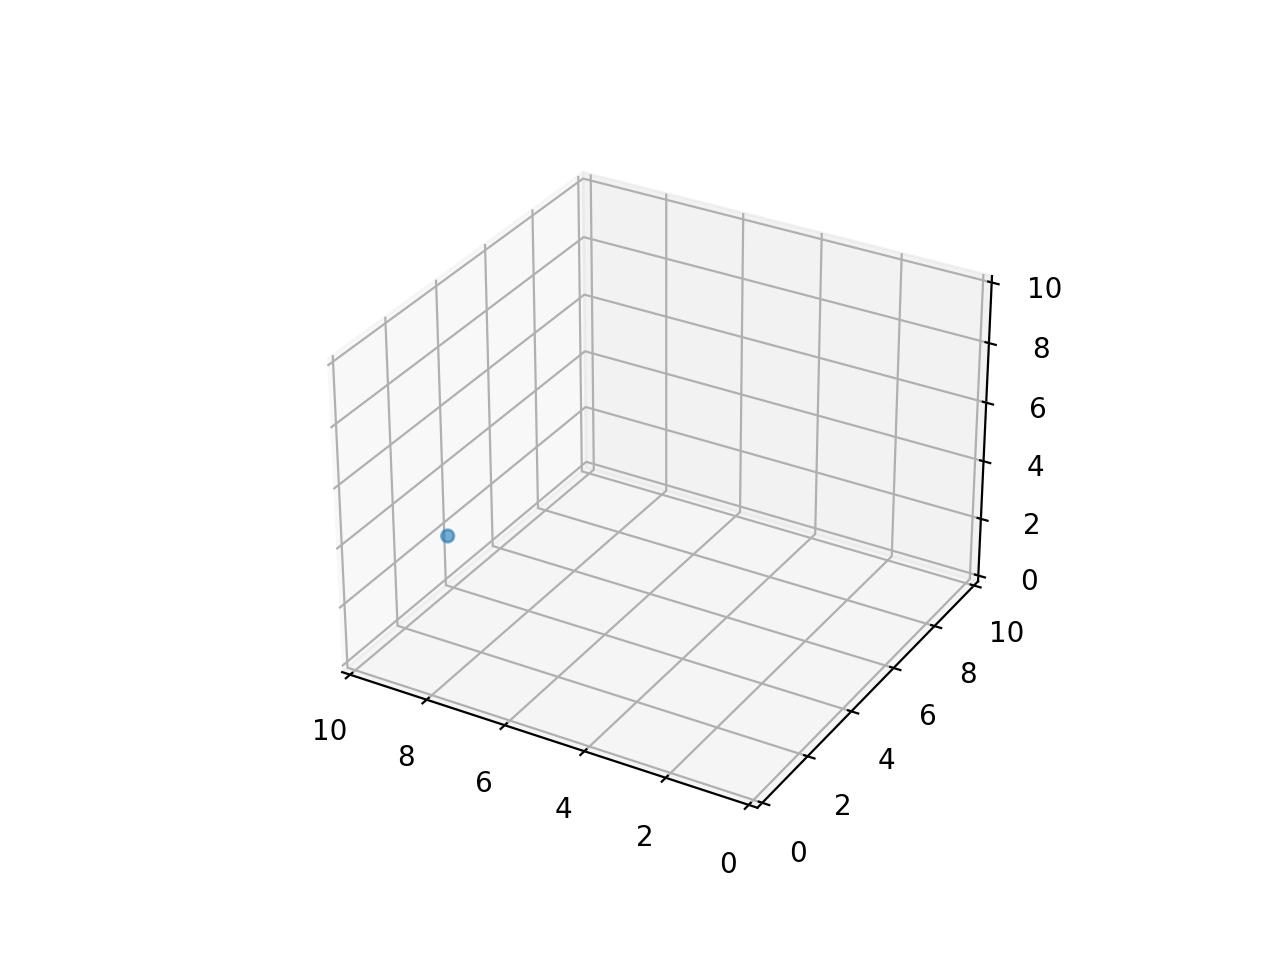

In [31]:
%matplotlib notebook

# Adapted from
# https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

##############################################################
fig = plt.figure()                                           #
ax = fig.add_subplot(111, projection='3d')                   #
#Creating a global variable scat to store particle positions #
scat = ax.scatter([], [], [])                                #
##############################################################

my_timer = 0 
dt = 0.01

def init():
    """
    Creates my starting particle positions on the graph
    """
    ax.clear()
    ax.set_xlim3d([0, 10])
    ax.invert_xaxis()
    ax.set_ylim3d([0, 10])
    ax.set_zlim3d([0, 10])
    scat = ax.scatter(
        [particle[0] for particle in table[my_timer]],
        [particle[1] for particle in table[my_timer]],
        [particle[2] for particle in table[my_timer]]
    )
    return scat,

def animate(frame):
    global my_timer, dt
    scat._offsets3d = (
        [particle[0] for particle in table[my_timer]],
        [particle[1] for particle in table[my_timer]],
        [particle[2] for particle in table[my_timer]]
    )
    my_timer += dt
    return scat,

#Interval here delays the time per frame shown
ani = FuncAnimation(fig, animate, frames=duration, init_func=init, blit=False, interval = 100)
plt.show()

### Key Takeaways
- Particles can bounce off the boundaries, similar to bouncing off the sides of a box.
- Particles will eventually flatten out, demonstrating the effects of gravity

## Fluid Models: Water Drop
In another model (which we shall not run, because it takes very long), we simulate a drop of water landing. In order to simulate this, our initial particles will be generated in a small area far away from the boundaries of the box. We have attached a video of the outcome in the next section.

## Extra Videos
Just in case the code doesn't run fast enough.

<video width="800" height="600" controls src="dam_break_video.mp4" />

<video width="800" height="600" controls src="water_drop.mp4" />

# Conclusion
In this notebook, we have aimed to:
- Highlight the importance of modeling fluid dynamics.
- Demonstrate the ability of Python to model particle interactions.
- Demonstrate how particle interactions can model fluid dynamics.

Our work is supported by [literature](https://pysph.readthedocs.io/en/latest/overview.html#research-papers-using-pysph) and professionally developed solutions such as [PySPH](https://pysph.readthedocs.io), which comes with nearly 100 pre-built test cases to show the use of Python in modeling fluid dynamics. PySPH has been undergoing development for the [almost fifteen years now](https://pysph.readthedocs.io/en/latest/overview.html#history), and is therefore far more optimized than anything we can write in one semester. Referring to the [rubrics](https://sps.nus.edu.sg/sp2273/assessment.html#rubric-for-presentation),

> Suitable packages and functions are appropriately used without reinventing the wheel

We therefore explore the use of PySPH in an appendix (included in a separate notebook, as it requires the installation of the PySPH package - a nonstandard installation for SP2273).

## Summary
Python is a powerful tool for exploring systems with no closed solutions. It allows us to use numerical methods to approximate the system, and perform large numbers of calculations to increase the accuracy and speed of our models.

# References
All our references have been consistently hyperlinked above, but here is a compilation of the links and where they go to for your convenience.

## Sources
- [Fluid dynamics (Wikipedia)](https://en.wikipedia.org/wiki/Fluid_dynamics)
- [Applications to biomedical engineering](https://pubmed.ncbi.nlm.nih.gov/34476751/)
- [Applications to disaster protection](https://link.springer.com/chapter/10.1007/978-3-211-69356-8_1)
- [Applications to industrial design](https://www.dynamiq-eng.co.uk/pages/Fluid_mechanics_dynamics.php)
- [Applications to astrophysics](https://arxiv.org/abs/1109.2219)
- [Fluid mechanics (Wikipedia)](https://en.wikipedia.org/wiki/Fluid_mechanics)
- [$Bi_4O_4SeCl_2$, the worst thermal conductor in the world](https://www.sciencealert.com/sustainability-win-scientists-make-material-with-the-lowest-thermal-conductivity-yet)
- [Continuum assumption](http://pillars.che.pitt.edu/student/slide.cgi?course_id=10&slide_id=5.0)
- [Navier Stokes](https://en.wikipedia.org/wiki/Navier–Stokes_existence_and_smoothness)
- [What is computational fluid dynamics](https://www.simscale.com/docs/simwiki/cfd-computational-fluid-dynamics/what-is-cfd-computational-fluid-dynamics/)
- [Dan Price and SPH](https://arxiv.org/abs/1111.1259)
- [Gaussian kernel](https://pages.stat.wisc.edu/~mchung/teaching/MIA/reading/diffusion.gaussian.kernel.pdf.pdf)
- [$n$-body problem](https://en.wikipedia.org/wiki/N-body_problem)
- [Dam break problem](https://www.worldscientific.com/doi/pdf/10.1142/9789813223882_0001)
- [Dam break explained](https://pysph.readthedocs.io/en/latest/design/overview.html?highlight=dam%20break#the-dam-break-problem)
- [PySPH package](https://pysph.readthedocs.io/en/latest/)
- [PySPH history](https://pysph.readthedocs.io/en/latest/overview.html#history)
- [SP2273 presentation rubrics](https://sps.nus.edu.sg/sp2273/assessment.html#rubric-for-presentation)

## Images
- [Bowl of water (Shutterstock)](https://www.shutterstock.com/image-vector/water-bowl-illustration-vector-cartoon-260nw-2210641359.jpg)
- [Navier Stokes equations (NASA)](https://www.grc.nasa.gov/www/k-12/airplane/Images/nseqs.gif)
- [Gaussian kernel](http://www.imagemet.com/WebHelp6/Content/Images/Gauss3D.png)

# Appendix: PySPH
We further explore PySPH and how it works in a separate notebook. Do note that running the appendix notebook needs PySPH to be installed.